In [14]:
from helpers import get_sample
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from tabulate import tabulate

models = [
    # Biophysical models
    'gagge',
    'ji',
    'takahashi',
    # Basic ML models
    'ml_ridge_regression',
    'ml_linear_regression',
    'ml_neural_network',
    'ml_decision_tree',
    'ml_lasso_regression',
    # 'ml_bagging_regression',
    # 'ml_random_forest',
    # Sequential ML models
    'ml_rnn',
    'ml_lstm',
	'ml_gru',
	'ml_tcn',
	'ml_seq2seq'
]

studies = [
    'heatwave 1 (prolonged)',
    'heatwave 3 (cooling)',
    'heatwave 2 (indoor)'
]

conditions = [
    'hot',
    'warm',
    'temp',
    'cool'
]

test_ids = [61, 97, 50, 83, 81, 75, 96, 36, 72, 62, 27, 84, 63, 69, 79, 42, 92,
            88, 33, 55, 64, 54, 93, 45, 29, 47, 48, 38, 57, 90, 41]

In [15]:
# COMPILE DATASET

# List of samples, each item is a dataframe for that particular experiment
# The dataframe contains the dataset, as well as the predicted values
samples = []

for study in studies:
    for condition in conditions:
        sample = get_sample(study, condition)
        # Drop index
        sample = sample.reset_index(drop=True)
        if (sample.shape[0] > 0):
            # Sample exists
            for model in models:
                try:
                    predicted = pd.read_csv('./results/{}-{}-{}.csv'.format(model, study, condition), header=0, names=['tre_predicted', 'mtsk_predicted'])
                    if predicted['tre_predicted'].dtype != 'float64':
                        print('./results/{}-{}-{}.csv tre_predicted needs to be cast to numeric'.format(model, study, condition))
                        predicted['tre_predicted'] = pd.to_numeric(predicted['tre_predicted'], errors='coerce')
                    if predicted['mtsk_predicted'].dtype != 'float64':
                        print('./results/{}-{}-{}.csv mtsk_predicted needs to be cast to numeric'.format(model, study, condition))
                        predicted['mtsk_predicted'] = pd.to_numeric(predicted['mtsk_predicted'], errors='coerce')
                    # Rename columns
                    tre_columm = 'tre_predicted_{}'.format(model)
                    mtsk_columm = 'mtsk_predicted_{}'.format(model)
                    predicted.rename(columns={'tre_predicted': tre_columm, 'mtsk_predicted': mtsk_columm}, inplace=True)
                    # Concat prediction to dataframe
                    sample = pd.concat([sample, predicted], axis=1)
                except:
                    print("File not found:", './results/{}-{}-{}.csv'.format(model, study, condition))
            # Remove any IDs that don't appear in test_ids
            sample = sample[sample['id_all'].isin(test_ids)]
            # Save sample to compiled results
            sample.to_csv('results_compiled/{}-{}.csv'.format(study,condition))
            samples.append(sample)

In [16]:
# Merge all samples together
merged_samples = pd.concat(samples, ignore_index=True)

# Calculate body temperature using the formula Tb = 0.64Tc * 0.36Tsk
merged_samples['tb'] = 0.64 * merged_samples['tre_int'] + 0.36 * merged_samples['mtsk_int']

# Define an empty list to store results
results = []

# Calculate RMSE for each model
for model in models:
    tre_col = 'tre_predicted_{}'.format(model)
    mtsk_col = 'mtsk_predicted_{}'.format(model)
    if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
        # Calculate body temperature using the predicted values
        merged_samples['tb_predicted_{}'.format(model)] = 0.64 * merged_samples[tre_col] + 0.36 * merged_samples[mtsk_col]

        # Calculate and round RMSE for tre
        tre_rmse = round(np.sqrt(mean_squared_error(merged_samples[tre_col], merged_samples['tre_int'])), 2)

        # Calculate and round RMSE for mtsk
        mtsk_rmse = round(np.sqrt(mean_squared_error(merged_samples[mtsk_col], merged_samples['mtsk_int'])), 2)

        # Calculate and round RMSE for tb
        tb_rmse = round(np.sqrt(mean_squared_error(merged_samples['tb_predicted_{}'.format(model)], merged_samples['tb'])), 2)

        # Calculate mean RMSE
        # mean_rmse = round((tre_rmse + mtsk_rmse + tb_rmse) / 3, 2)

        # Append results to list
        results.append([model, tre_rmse, mtsk_rmse, tb_rmse])
    else:
        print(f"Columns for model {model} not found in the merged data.")

# Convert the results list to DataFrame for better visualization and compatibility with tabulate
results_df = pd.DataFrame(results, columns=['Model', 'tre_RMSE', 'mtsk_RMSE', 'tb_RMSE'])

# Sort by RMSE
results_df = results_df.sort_values(by='tre_RMSE')

# Convert the DataFrame to LaTeX table
latex_table = tabulate(results_df, tablefmt="latex", headers="keys", showindex=False)

print(latex_table)

\begin{tabular}{lrrr}
\hline
 Model                &   tre\_RMSE &   mtsk\_RMSE &   tb\_RMSE \\
\hline
 ml\_ridge\_regression  &       0.29 &        0.8  &      0.37 \\
 ml\_linear\_regression &       0.3  &        0.86 &      0.39 \\
 ml\_gru               &       0.38 &        1.35 &      0.64 \\
 ji                   &       0.41 &        1.89 &      0.62 \\
 ml\_rnn               &       0.43 &        1.5  &      0.73 \\
 ml\_lstm              &       0.43 &        1.39 &      0.69 \\
 takahashi            &       0.45 &        1.18 &      0.62 \\
 ml\_seq2seq           &       0.45 &        1.54 &      0.76 \\
 ml\_tcn               &       0.47 &        1.78 &      0.87 \\
 ml\_lasso\_regression  &       0.49 &        1.85 &      0.91 \\
 ml\_decision\_tree     &       0.55 &        1.72 &      0.84 \\
 gagge                &       0.58 &        0.87 &      0.57 \\
 ml\_neural\_network    &       0.68 &        1.45 &      0.68 \\
\hline
\end{tabular}


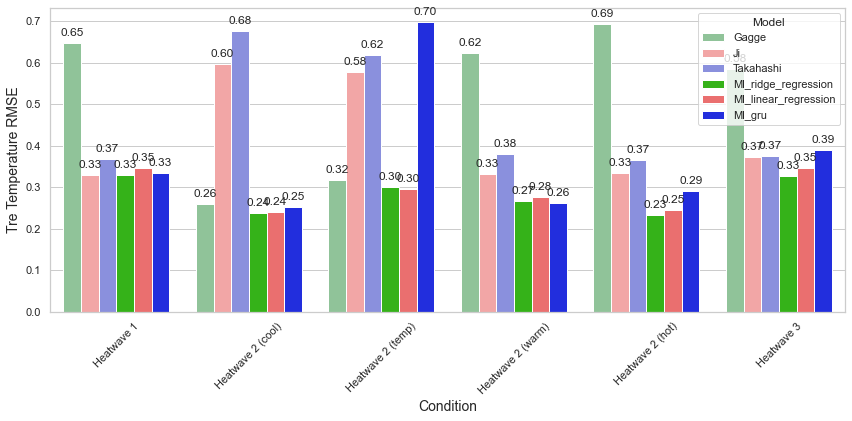

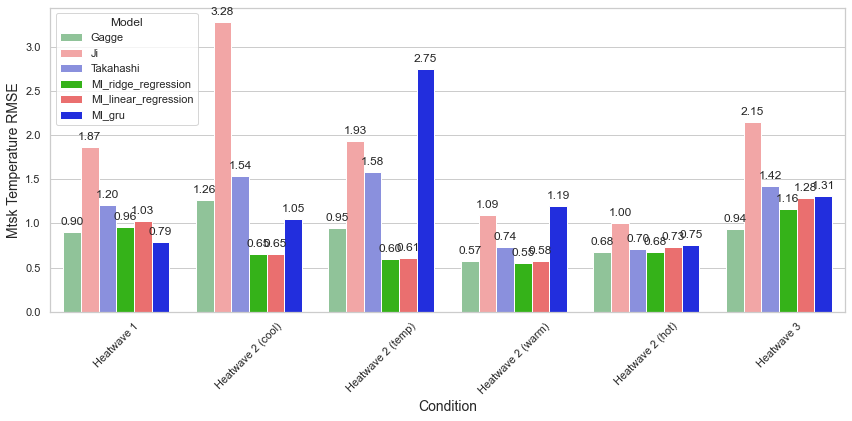

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

def plot_rmse(samples, models, temp_type):
    # To store the MSE of each model for each condition
    rmse_dict = {}

    # Loop over each sample DataFrame
    for sample_idx, sample in enumerate(samples):
        study = sample.study.iloc[0]
        condition = sample.condition.iloc[0]

        # For each model, calculate the MSE and store it
        for model in models:
            model_column = f'{temp_type}_predicted_{model}'
            if model_column in sample.columns:
                mse = mean_squared_error(sample[f'{temp_type}_int'], sample[model_column])
                rmse = sqrt(mse)
                # Store the MSE in the dictionary
                rmse_dict[(study, condition, model)] = rmse
            else:
                print(f"Column {model_column} not found in {study} {condition} dataframe.")

    # Set the style and increase the size of the plot
    sns.set(style="whitegrid")
    sns.set_palette(sns.color_palette(['#87CC94', '#FF9999', '#7c84eb', '#25CB00', '#FF5A5A', '#0313fc']))
    plt.figure(figsize=(12, 6))

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(list(rmse_dict.items()), columns=['Key', 'RMSE'])
    df[['Study', 'Condition', 'Model']] = pd.DataFrame(df['Key'].tolist(), index=df.index)
    df = df.drop(columns='Key')

    # Capitalize the first letter of each model
    df['Model'] = df['Model'].str.capitalize()

    # Create a new column that combines 'Study' and 'Condition'
    df['StudyCondition'] = df['Study'] + ' - ' + df['Condition']

    # Remap labels
    remap_dict = {
        'heatwave 1 (prolonged) - hot': 'Heatwave 1',
        'heatwave 2 (indoor) - cool': 'Heatwave 2 (cool)',
        'heatwave 2 (indoor) - temp': 'Heatwave 2 (temp)',
        'heatwave 2 (indoor) - warm': 'Heatwave 2 (warm)',
        'heatwave 2 (indoor) - hot': 'Heatwave 2 (hot)',
        'heatwave 3 (cooling) - hot': 'Heatwave 3',
    }
    df['StudyCondition'] = df['StudyCondition'].replace(remap_dict)

    # Melt the DataFrame back to long format for seaborn
    df_melt = df.melt(id_vars=['StudyCondition', 'Model'], value_vars='RMSE')

    # Plot the grouped bar chart
    ax = sns.barplot(x='StudyCondition', y='value', hue='Model', data=df_melt)

    # Add a value label to each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

    plt.ylabel(f'{temp_type.capitalize()} Temperature RMSE', fontsize=14)
    plt.xlabel('Condition', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save figure
    plt.savefig(f"figures/{temp_type}_rmse_chart.pdf", format='pdf')
    plt.show()


# Example usage
models = [
    # Biophysical models
    'gagge', 'ji', 'takahashi',
    # ML models
    'ml_ridge_regression', 'ml_linear_regression', 'ml_gru',
]

# Plot Rectal Temperature RMSE
plot_rmse(samples, models, temp_type='tre')

# Plot Skin Temperature RMSE
plot_rmse(samples, models, temp_type='mtsk')

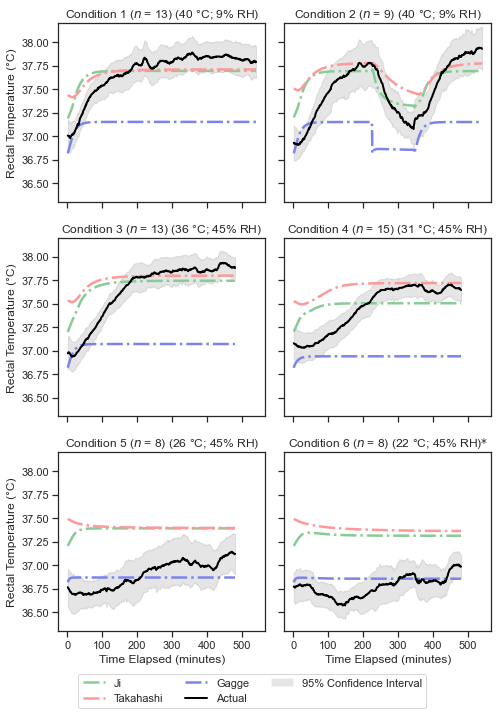

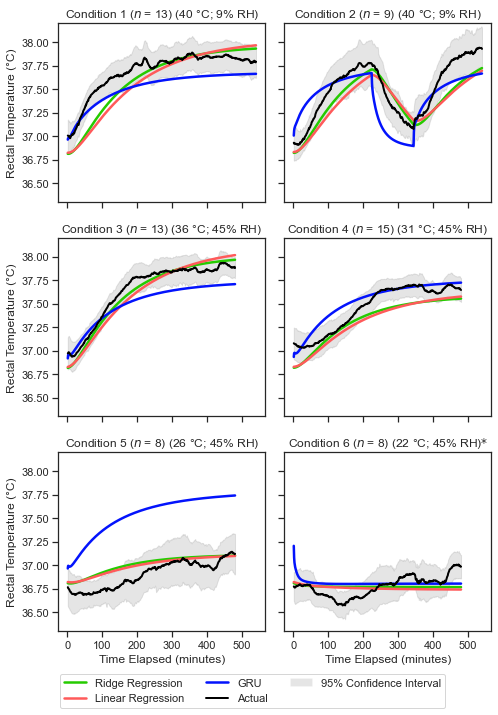

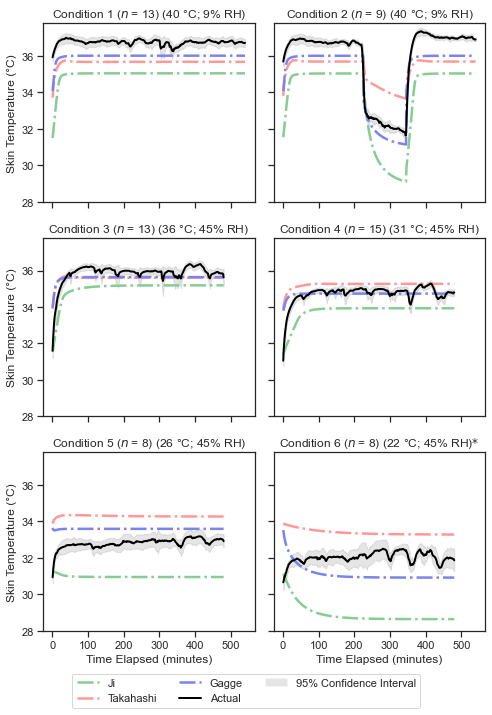

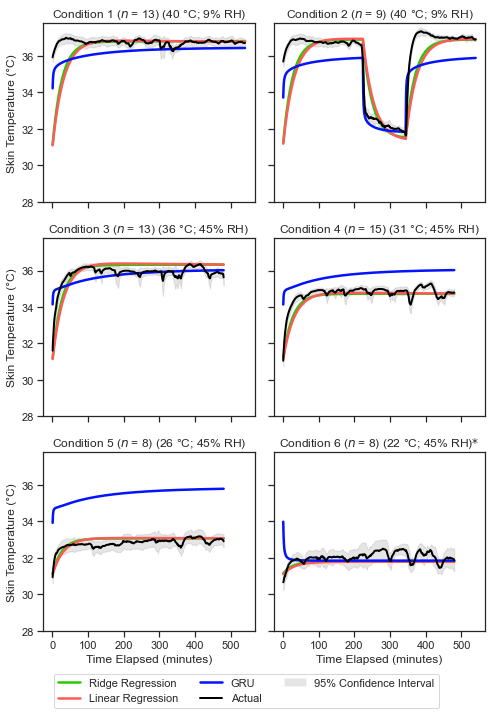

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

legend_labels = {
    'ji': 'Ji',
    'takahashi': 'Takahashi',
    'gagge': 'Gagge',
    'ml_ridge_regression': 'Ridge Regression',
    'ml_linear_regression': 'Linear Regression',
    'ml_gru': 'GRU',
}

def plot_models(samples, models, temp_type='tre', line_style='-', colors=['#25CB00', '#FF5A5A', '#0313fc']):
    temp_column = f'{temp_type}_int'
    sns.set(style="ticks")
    sns.set_palette(sns.color_palette(colors))

    rows, cols = 3, 2
    fig, axs = plt.subplots(rows, cols, figsize=(7, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    handles = []
    labels = [legend_labels[model] for model in models] + ["Actual"]

    for idx, sample in enumerate(samples):
        study = sample.study.iloc[0]
        condition = sample.condition.iloc[0]
        sample = sample[sample.age >= 60]
        sample_grouped = sample.groupby('time').mean()
        sample_grouped_ci = sample.groupby('time').agg({temp_column: ['mean', 'sem']})

        # Calculate the 95% confidence interval
        sample_grouped_ci[temp_column, 'ci_lower'] = sample_grouped_ci[temp_column]['mean'] - 1.96 * sample_grouped_ci[temp_column]['sem']
        sample_grouped_ci[temp_column, 'ci_upper'] = sample_grouped_ci[temp_column]['mean'] + 1.96 * sample_grouped_ci[temp_column]['sem']

        # Plotting the predicted data
        for model in models:
            model_column = f'{temp_type}_predicted_{model}'
            if model_column in sample_grouped.columns:
                line, = axs[idx].plot(sample_grouped.index, sample_grouped[model_column], linewidth=2.5, linestyle=line_style)
                # Append the line handle and label to the lists
                if idx == 0:
                    handles.append(line)
            else:
                print(f"Column {model_column} not found in {study} {condition} dataframe.")

        # Plotting the actual data
        line, = axs[idx].plot(sample_grouped.index, sample_grouped[temp_column], linewidth=2, color="black")
        if idx == 0:
            handles.append(line)

        # Plot 95% confidence interval as shaded area
        axs[idx].fill_between(sample_grouped.index,
                              sample_grouped_ci[temp_column, 'ci_lower'],
                              sample_grouped_ci[temp_column, 'ci_upper'],
                              color='gray', alpha=0.2)

        axs[idx].set_title('Condition {} ($n$ = {}) ({} °C; {}% RH)'.format(
            idx+1, len(sample.id_all.unique()), sample.ta_set.iloc[0], sample.rh_set.iloc[0]
        ))
        if idx == 5:
            axs[idx].set_title('Condition {} ($n$ = {}) ({} °C; {}% RH)$*$'.format(
                idx+1, len(sample.id_all.unique()), sample.ta_set.iloc[0], sample.rh_set.iloc[0]
            ))

        if temp_type == 'tre':
            axs[idx].set_ylim(36.3, 38.2)
        else:
            axs[idx].set_ylim(28.0, 37.8)

        if idx % cols != 0:
            axs[idx].set_ylabel("")
        else:
            axs[idx].set_ylabel(f"{'Rectal' if temp_column == 'tre_int' else 'Skin'} Temperature (°C)")

        if idx < (rows - 1) * cols:
            axs[idx].set_xlabel("")
        else:
            axs[idx].set_xlabel("Time Elapsed (minutes)")

    # Create a handle and label for the 95% confidence interval shaded area
    ci_handle = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.2)
    ci_label = '95% Confidence Interval'
    handles.append(ci_handle)
    labels.append(ci_label)

    for idx_unused in range(len(samples), rows*cols):
        fig.delaxes(axs[idx_unused])

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"figures/{temp_type}_line_chart_{'ml' if 'ml' in models[0] else 'biophysical'}.pdf", format='pdf', dpi=300)
    plt.show()

# Biophysical models
biophysical_models = ['ji', 'takahashi', 'gagge']

# ML models
ml_models = ['ml_ridge_regression', 'ml_linear_regression', 'ml_gru']

# Plot rectal temperature for biophysical models
plot_models(samples, biophysical_models, temp_type='tre', line_style='-.', colors=['#87CC94', '#FF9999', '#7c84eb'])

# Plot rectal temperature for ML models
plot_models(samples, ml_models, temp_type='tre', line_style='-', colors=['#25CB00', '#FF5A5A', '#0313fc'])

# Plot skin temperature for biophysical models
plot_models(samples, biophysical_models, temp_type='mtsk', line_style='-.', colors=['#87CC94', '#FF9999', '#7c84eb'])

# Plot skin temperature for ML models
plot_models(samples, ml_models, temp_type='mtsk', line_style='-', colors=['#25CB00', '#FF5A5A', '#0313fc'])

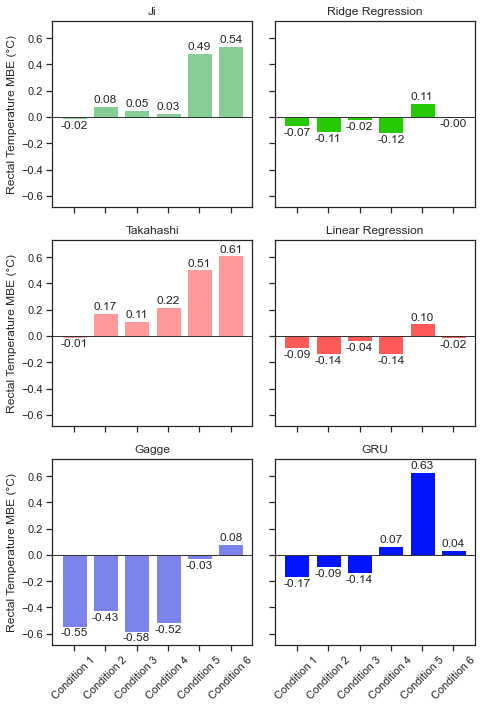

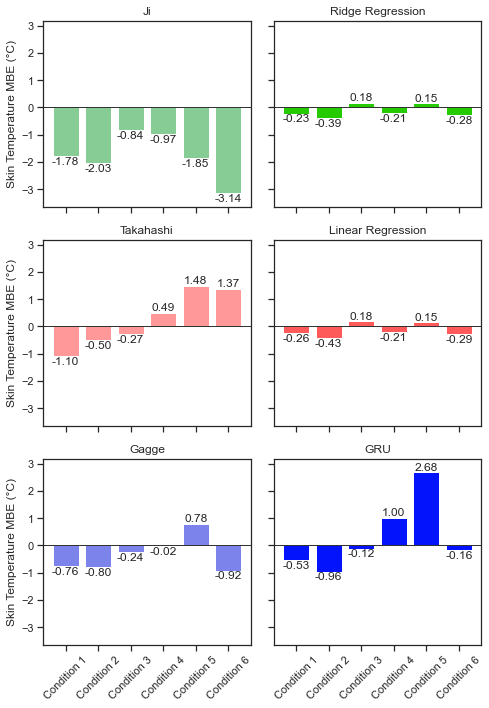

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_mbe(actual, predicted):
    return np.mean(predicted - actual)

def plot_mbe(samples, models, model_labels, model_colors, temp_type='tre'):
    rows, cols = 3, 2
    fig, axs = plt.subplots(rows, cols, figsize=(7, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    global_min_mbe = float('inf')
    global_max_mbe = float('-inf')

    for idx, model in enumerate(models):
        mbe_values = []
        for sample in samples:
            actual = sample[f'{temp_type}_int']
            predicted = sample[f'{temp_type}_predicted_{model}']
            mbe = calculate_mbe(actual, predicted)
            mbe_values.append(mbe)
            global_min_mbe = min(global_min_mbe, mbe)
            global_max_mbe = max(global_max_mbe, mbe)

        bars = axs[idx].bar(range(1, len(samples) + 1), mbe_values, color=model_colors[idx])
        axs[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        axs[idx].set_title(model_labels[idx])
        axs[idx].set_xticks(range(1, len(samples) + 1))
        axs[idx].set_xticklabels([f'Condition {i+1}' for i in range(len(samples))])
        axs[idx].tick_params(axis='x', rotation=45)

        for bar, mbe in zip(bars, mbe_values):
            height = bar.get_height()
            if mbe >= 0:
                axs[idx].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{mbe:.2f}', ha='center', va='bottom', fontsize=12)
            else:
                axs[idx].text(bar.get_x() + bar.get_width() / 2, height - 0.01, f'{mbe:.2f}', ha='center', va='top', fontsize=12)

        if idx % cols == 0:
            if temp_type == 'tre':
                axs[idx].set_ylabel('Rectal Temperature MBE (°C)')
            else:
                axs[idx].set_ylabel('Skin Temperature MBE (°C)')

    # Set y-axis limits with extra room based on global minimum and maximum MBE values
    offset = 0.5
    if temp_type == 'tre':
        offset = 0.1
    y_min = global_min_mbe - offset
    y_max = global_max_mbe + offset
    for ax in axs:
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.savefig(f"figures/{temp_type}_mbe_barchart.pdf", format='pdf', dpi=300)
    plt.show()

# Example usage
# models = ['ji', 'takahashi', 'gagge', 'ml_ridge_regression', 'ml_linear_regression', 'ml_gru']
# model_labels = ['Ji', 'Takahashi', 'Gagge', 'Ridge Regression', 'Linear Regression', 'GRU']
# model_colors = ['#87CC94', '#FF9999', '#7c84eb', '#25CB00', '#FF5A5A', '#0313fc']

models = ['ji', 'ml_ridge_regression', 'takahashi', 'ml_linear_regression', 'gagge', 'ml_gru']
model_labels = ['Ji', 'Ridge Regression', 'Takahashi', 'Linear Regression', 'Gagge', 'GRU']
model_colors = ['#87CC94', '#25CB00', '#FF9999', '#FF5A5A', '#7c84eb', '#0313fc']

# Plot MBE for rectal temperature (tre)
plot_mbe(samples, models, model_labels, model_colors, temp_type='tre')

# Plot MBE for mean skin temperature (mtsk)
plot_mbe(samples, models, model_labels, model_colors, temp_type='mtsk')

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_mbe(actual, predicted):
    return np.mean(predicted - actual)


def generate_latex_table(samples, models, model_labels, temp_type='tre'):
    table = "\\begin{table}[]\n"
    table += "\\centering\n"
    table += "\\begin{tabular}{" + "l" * (len(samples) + 1) + "}\n"
    table += "\\hline\n"
    table += "Model & " + " & ".join(f"Condition {i+1}" for i in range(len(samples))) + " \\\\\n"
    table += "\\hline\n"

    for idx, model in enumerate(models):
        mbe_values = []
        for sample in samples:
            actual = sample[f'{temp_type}_int']
            predicted = sample[f'{temp_type}_predicted_{model}']
            mbe = calculate_mbe(actual, predicted)
            mbe_values.append(f"{mbe:.2f}")

        table += f"{model_labels[idx]} & " + " & ".join(mbe_values) + " \\\\\n"

    table += "\\hline\n"
    table += "\\end{tabular}\n"
    table += f"\\caption{{MBE results for {temp_type} temperature}}\n"
    table += f"\\label{{tab:{temp_type}_mbe}}\n"
    table += "\\end{table}\n"

    return table

# Example usage
models = ['ji', 'ml_ridge_regression', 'takahashi', 'ml_linear_regression', 'gagge', 'ml_gru']
model_labels = ['Ji', 'Ridge Regression', 'Takahashi', 'Linear Regression', 'Gagge', 'GRU']
model_colors = ['#87CC94', '#25CB00', '#FF9999', '#FF5A5A', '#7c84eb', '#0313fc']

# Generate LaTeX table for rectal temperature (tre)
tre_table = generate_latex_table(samples, models, model_labels, temp_type='tre')
print("Rectal Temperature MBE Table:")
print(tre_table)

# Generate LaTeX table for mean skin temperature (mtsk)
mtsk_table = generate_latex_table(samples, models, model_labels, temp_type='mtsk')
print("Mean Skin Temperature MBE Table:")
print(mtsk_table)

Rectal Temperature MBE Table:
\begin{table}[]
\centering
\begin{tabular}{lllllll}
\hline
Model & Condition 1 & Condition 2 & Condition 3 & Condition 4 & Condition 5 & Condition 6 \\
\hline
Ji & -0.02 & 0.54 & 0.49 & 0.03 & 0.05 & 0.08 \\
Ridge Regression & -0.07 & -0.00 & 0.11 & -0.12 & -0.02 & -0.11 \\
Takahashi & -0.01 & 0.61 & 0.51 & 0.22 & 0.11 & 0.17 \\
Linear Regression & -0.09 & -0.02 & 0.10 & -0.14 & -0.04 & -0.14 \\
Gagge & -0.55 & 0.08 & -0.03 & -0.52 & -0.58 & -0.43 \\
GRU & -0.17 & 0.04 & 0.63 & 0.07 & -0.14 & -0.09 \\
\hline
\end{tabular}
\caption{MBE results for tre temperature}
\label{tab:tre_mbe}
\end{table}

Mean Skin Temperature MBE Table:
\begin{table}[]
\centering
\begin{tabular}{lllllll}
\hline
Model & Condition 1 & Condition 2 & Condition 3 & Condition 4 & Condition 5 & Condition 6 \\
\hline
Ji & -1.78 & -3.14 & -1.85 & -0.97 & -0.84 & -2.03 \\
Ridge Regression & -0.23 & -0.28 & 0.15 & -0.21 & 0.18 & -0.39 \\
Takahashi & -1.10 & 1.37 & 1.48 & 0.49 & -0.27 & -0.50 